In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models, utils
from sklearn.model_selection import train_test_split
import pandas as pd

# Prepare dataset

In [5]:
IMG_SIZE = 500
BATCH_SIZE = 64

all_class = ["normal", "bacteria", "virus"]
class_map = {cls:i for i,cls in enumerate(all_class)}
class_map

{'bacteria': 1, 'normal': 0, 'virus': 2}

In [6]:
# read all paths
img_paths_all = glob("pneumonia/train/*/*.jpeg")
img_paths_test = sorted(glob("pneumonia/test/*.jpeg"))
img_paths_train, img_paths_val = train_test_split(img_paths_all,test_size=0.2)

(1245, 1462, 3)


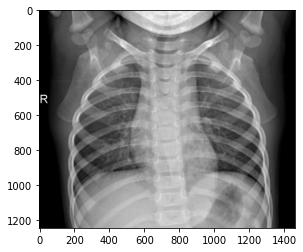

In [7]:
img = cv2.imread(img_paths_all[1])
plt.imshow(img)
print(img.shape)

In [8]:
# number of images
len(img_paths_train), len(img_paths_val), len(img_paths_test)

(4172, 1044, 624)


[0. 1. 2.] [1341 2530 1345]


<BarContainer object of 3 artists>

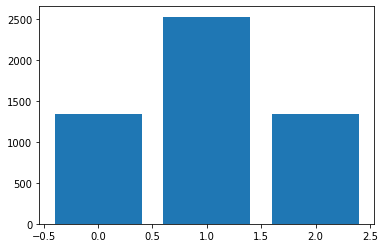

In [9]:
data_count = len(img_paths_all)
y = np.zeros((data_count, ))

for i, path in tqdm(enumerate(img_paths_all)):
  cls = path.split("/")[-2].lower()
  if cls == "pneumonia":
    # get filename
    filename = path.split(os.sep)[-1]
    # get pneumonia subclass
    cls_pneumonia = filename.split("_")[1]
    cls_idx = class_map[cls_pneumonia]
  # for normal class
  else:
    cls_idx = class_map[cls]
  y[i] = cls_idx

# label count
unique_classes, counts = np.unique(y, return_counts=True)
print(unique_classes, counts)

plt.bar(unique_classes, counts)

In [10]:
# Class Weight Calculation

print("data_count: ",data_count)
print(unique_classes, counts)

weight = (1/counts) * np.sum(counts) / len(unique_classes)
class_weight = {i:w for i, w in enumerate(weight)}
print("class_weight:",class_weight)

data_count:  5216
[0. 1. 2.] [1341 2530 1345]
class_weight: {0: 1.2965448670146655, 1: 0.6872200263504612, 2: 1.2926889714993803}


In [11]:
class DataGenerator(utils.Sequence):
  def __init__(self, paths, batch_size, img_size, mode="train"):
    self.paths = paths
    self.batch_size = batch_size
    self.shuffle = mode == "train"
    self.indexes = np.arange(len(self.paths))
    all_class = ["normal", "bacteria", "virus"] 
    self.class_map = {cls:i for i,cls in enumerate(all_class)}
    self.num_classes = len(self.class_map)
    self.img_size = img_size
    self.mode = mode
    self.on_epoch_end()
  
  def __len__(self):
    "number of　batches per epoch"
    return int(np.ceil( len(self.paths)/self.batch_size ))

  def __getitem__(self, index):
    "Generate one batch of data"
    # Generate one index of the batch
    idxs = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
    # Find list of IDs
    batch_paths = [self.paths[i] for i in idxs]
    # Generate data
    return self.__data_generation(batch_paths)

  def on_epoch_end(self):
    "Updates indexes after each epoch"
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, paths):
    """
    Generates data containing batch_size sample
    """
    x = np.empty((len(paths), self.img_size, self.img_size, 3), dtype=np.float32)
    y = np.empty((len(paths)))

    for i, path in enumerate(paths):
      img = cv2.imread(path)[:,:,::-1]
      # img preprocess
      img = cv2.resize(img, (self.img_size, self.img_size))
      img = tf.keras.applications.efficientnet.preprocess_input(img)
      if self.mode != "test":
        # read class label
        cls = path.split(os.sep)[-2].lower()
        if cls == "pneumonia":
          # get filename
          filename = path.split(os.sep)[-1]
          # get pneumonia subclass
          cls_pneumonia = filename.split("_")[1]
          cls_idx = class_map[cls_pneumonia]
        # for normal class
        else:
          cls_idx = class_map[cls]
        y[i] = cls_idx
      x[i] = img

    if self.mode != "test":
      # one-hot encofing
      y = tf.keras.utils.to_categorical(y, num_classes=self.num_classes)
      return x, y
    else:
      return x


In [12]:
gen_train = DataGenerator(img_paths_train, BATCH_SIZE, IMG_SIZE, mode="train")
gen_val = DataGenerator(img_paths_val, BATCH_SIZE, IMG_SIZE, mode="val")
gen_test = DataGenerator(img_paths_test, BATCH_SIZE, IMG_SIZE, mode="test")

# Bulid model

In [13]:
# Method 1
tf.keras.backend.clear_session()

base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=(IMG_SIZE,IMG_SIZE,3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.3)(x)


predictions = layers.Dense(3, activation="softmax")(x)

for l in base_model.layers:
  l.trainable = False

model = models.Model(base_model.input, predictions)

16711680/16705208 [==============================] - 0s 0us/step


# Training

In [14]:
model.compile(optimizer="adam",
       loss= tf.keras.losses.categorical_crossentropy,
       metrics=[tf.keras.metrics.categorical_accuracy])

In [15]:
logs = model.fit(gen_train,
          epochs=50,
          validation_data=gen_val,
          #class_weight=class_weight, # Add class weight
          callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=20),
            tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, save_weights_only=True),
            tf.keras.callbacks.ReduceLROnPlateau("val_loss", factor=0.2, patience=3, min_lr=0.001)
          ]
          )

Epoch 1/50
66/66 [==============================] - 183s 2s/step - loss: 0.8420 - categorical_accuracy: 0.6465 - val_loss: 0.7101 - val_categorical_accuracy: 0.7174
Epoch 2/50
66/66 [==============================] - 142s 2s/step - loss: 0.6076 - categorical_accuracy: 0.7507 - val_loss: 0.5265 - val_categorical_accuracy: 0.7941
Epoch 3/50
66/66 [==============================] - 141s 2s/step - loss: 0.5354 - categorical_accuracy: 0.7812 - val_loss: 0.5366 - val_categorical_accuracy: 0.7711
Epoch 4/50
66/66 [==============================] - 142s 2s/step - loss: 0.5094 - categorical_accuracy: 0.7855 - val_loss: 0.4627 - val_categorical_accuracy: 0.8056
Epoch 5/50
66/66 [==============================] - 143s 2s/step - loss: 0.4865 - categorical_accuracy: 0.7936 - val_loss: 0.5184 - val_categorical_accuracy: 0.7797
Epoch 6/50
66/66 [==============================] - 143s 2s/step - loss: 0.4717 - categorical_accuracy: 0.8001 - val_loss: 0.4525 - val_categorical_accuracy: 0.8036
Epoch 7/50

# Training logs

Text(0.5, 1.0, 'Accuracy')

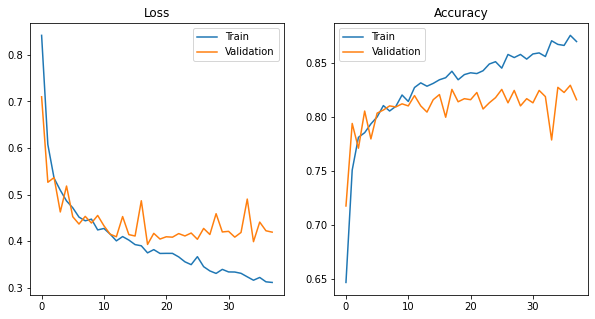

In [16]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(logs.history["loss"])
plt.plot(logs.history["val_loss"])
plt.legend(["Train","Validation"])
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(logs.history["categorical_accuracy"])
plt.plot(logs.history["val_categorical_accuracy"])
plt.legend(["Train","Validation"])
plt.title("Accuracy")

# Metrics

In [17]:
# load best model
model.load_weights("best.h5")

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.array([])
y_true = np.array([])

for x_val, y_val in tqdm(gen_val):
  pred = model.predict(x_val)
  y_pred = np.append(y_pred, np.argmax(pred, axis=-1))
  y_true = np.append(y_true, np.argmax(y_val, axis=-1))

In [19]:
# classification_report
print(classification_report(y_true, y_pred))

# Confusion matrix:
print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       270
         1.0       0.82      0.86      0.84       522
         2.0       0.67      0.60      0.63       252

    accuracy                           0.83      1044
   macro avg       0.82      0.81      0.81      1044
weighted avg       0.82      0.83      0.82      1044

[[263   4   3]
 [  2 449  71]
 [  6  96 150]]


In [ ]:
# classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       289
         1.0       0.80      0.83      0.81       502
         2.0       0.64      0.57      0.60       253

    accuracy                           0.81      1044
   macro avg       0.80      0.79      0.80      1044
weighted avg       0.80      0.81      0.81      1044



In [ ]:
# Confusion matrix:
print(confusion_matrix(y_true, y_pred))

[[286   3   0]
 [  7 416  79]
 [  7 103 143]]
